# Estudos TCC

# Instalando e Importando Bibliotecas


In [1]:
!pip install scikit-network
from sklearn.base import BaseEstimator, ClassifierMixin, RegressorMixin
from sklearn.datasets import fetch_openml, load_iris, load_digits, load_wine, load_breast_cancer
from sklearn.ensemble import RandomForestClassifier, StackingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import cross_val_score, KFold, train_test_split
from sklearn.neighbors import KNeighborsClassifier, kneighbors_graph
from sklearn.svm import SVC

from sknetwork.gnn import GNNClassifier

import matplotlib.pyplot as plt
import numpy as np
import warnings

warnings.filterwarnings('ignore')

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.7/4.7 MB 23.5 MB/s eta 0:00:00


# GCN Classifier

In [2]:
class GCNClassifier(BaseEstimator, ClassifierMixin):
    def __init__(self, dims, n_epochs=100, n_neighbors=3, train_data=[], test_data=[], features_like_dataset=False, features_by_results=True, concat_proba_graph=False, mode='connectivity', random_state=42, verbose=True):
        self.train_data = train_data
        self.test_data = test_data

        self.features_like_dataset = features_like_dataset
        self.features_by_results = features_by_results
        self.concat_proba_graph = concat_proba_graph
        self.n_neighbors = n_neighbors
        self.mode = mode

        self.random_state = random_state
        self.n_epochs = n_epochs
        self.verbose = verbose
        self.dims = dims

    def fit(self, X, y=None):
        self.x_train = X
        self.y_train = y

    def predict(self, X, y=None):
        y_all = np.concatenate((self.y_train, np.full(X.shape[0], -1)), axis=0)

        data_features = np.concatenate((self.train_data, self.test_data), axis=0)
        model_features = np.concatenate((self.x_train, X), axis=0)

        graph_connectors = data_features

        if self.concat_proba_graph:
            graph_connectors = np.concatenate((data_features, model_features), axis=1)

        knGraph = kneighbors_graph(graph_connectors, self.n_neighbors, mode=self.mode)
        nodes_features = None

        if self.features_like_dataset:
            nodes_features = data_features
        elif self.features_by_results:
            nodes_features = model_features
        else:
            nodes_features = np.concatenate((data_features, model_features), axis=1)

        gnn = GNNClassifier(dims=self.dims,
                            layer_types='Conv',
                            activations='ReLu',
                            verbose=self.verbose)

        gnn_predict = gnn.fit_predict(knGraph, nodes_features, y_all, n_epochs=self.n_epochs, random_state=self.random_state)

        return gnn_predict[self.x_train.shape[0] : ].astype(int)

# Dataset Run

In [3]:
def count_elements(array):
    unique_values, counts = np.unique(array, return_counts=True)

    # Print the results
    for value, count in zip(unique_values, counts):
        print(f"{value} --> {count}")

    return unique_values

In [4]:
class DatasetRun():
    data = []
    target = []
    n_labels = 2

    def __init__(self, data, target):
        self.data = data
        self.target = target

        unique_values = count_elements(target)
        self.n_labels = unique_values.shape[0]

    def split(self, test_size, to_be_stratified=False):
        stratify = None
        if to_be_stratified:
            stratify = self.target

        self.x_train, self.x_test, self.y_train, self.y_test = train_test_split(self.data, self.target, test_size=test_size, random_state=42, stratify=stratify, shuffle=True)
        count_elements(array=self.y_train)


    def run_base_estimators(self, n_folds=5, print_all_results=False):
        self.__train_estimators_parameters(n_folds, print_all_results)

        estimatorsArray = self.__doEstimatorsArray()

        for estimator in estimatorsArray:
            ml_method = estimator[1]
            ml_method.fit(self.x_train, self.y_train)
            accuracy = ml_method.score(self.x_test, self.y_test)
            print('Acurácia do método %s = %.4f\n' % (estimator[0], accuracy))


    def run_sc_lr(self):
        sc_lr = StackingClassifier(estimators=self.__doEstimatorsArray(), final_estimator=LogisticRegression())
        sc_lr.fit(self.x_train, self.y_train)

        accuracy = sc_lr.score(self.x_test, self.y_test)
        print('Acurácia do StackingClassifier padrão (com Logistic Regression): %.4f' % accuracy)


    def run_sc_gcn(self, n_epochs, dims=[], verbose=True, n_ct=5):
        dims.append(self.n_labels)

        gcnCustom0 = GCNClassifier(dims=dims,n_epochs=n_epochs,random_state=42,n_neighbors=n_ct,features_like_dataset=True, train_data=self.x_train,test_data=self.x_test,verbose=verbose)

        sc_gcn0 = StackingClassifier(estimators=self.__doEstimatorsArray(), final_estimator=gcnCustom0)
        sc_gcn0.fit(self.x_train, self.y_train)

        print('Acurácia do StackingGCN (Features = dataset): %.4f' % sc_gcn0.score(self.x_test, self.y_test))

        ######### STACKING CLASSIFIER WITH GCN (FEATURES = STACKING RESULTS)
        gcnCustom = GCNClassifier(dims=dims,n_epochs=n_epochs,random_state=42,n_neighbors=n_ct,train_data=self.x_train,test_data=self.x_test,verbose=verbose)

        sc_gcn = StackingClassifier(estimators=self.__doEstimatorsArray(), final_estimator=gcnCustom)
        sc_gcn.fit(self.x_train, self.y_train)

        print('Acurácia do StackingGCN (Features = stacking results): %.4f' % sc_gcn.score(self.x_test, self.y_test))

        ######### STACKING CLASSIFIER WITH GCN (FEATURES = DATASET + STACKING RESULTS)
        gcnCustom2 = GCNClassifier(dims=dims,n_epochs=n_epochs,random_state=42,n_neighbors=n_ct,features_by_results=False,train_data=self.x_train,test_data=self.x_test,verbose=verbose)

        sc_gcn2 = StackingClassifier(estimators=self.__doEstimatorsArray(), final_estimator=gcnCustom2)
        sc_gcn2.fit(self.x_train, self.y_train)

        print('Acurácia do StackingGCN (Features = dataset + stacking results): %.4f' % sc_gcn2.score(self.x_test, self.y_test))

    def get_classification_report(self, n_epochs, dims=[], n_ct=5, features_like_dataset=False, features_by_results=True):
        sc_lr = StackingClassifier(estimators=self.__doEstimatorsArray(), final_estimator=LogisticRegression())
        sc_lr.fit(self.x_train, self.y_train)
        lr_pred = sc_lr.predict(self.x_test)

        print(classification_report(self.y_test, lr_pred, digits=4))

        plt.figure()
        ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(self.y_test, lr_pred)).plot()
        plt.grid(False)
        plt.show()

        dims.append(self.n_labels)
        gcnClassifier = GCNClassifier(dims=dims, n_epochs=n_epochs, random_state=42,n_neighbors=n_ct,features_like_dataset=features_like_dataset, features_by_results=features_by_results, train_data=self.x_train,test_data=self.x_test,verbose=False)
        sc_gcn = StackingClassifier(estimators=self.__doEstimatorsArray(), final_estimator=gcnClassifier)
        sc_gcn.fit(self.x_train, self.y_train)
        gcn_pred = sc_gcn.predict(self.x_test)

        print(classification_report(self.y_test, gcn_pred, digits=4))

        plt.figure()
        ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(self.y_test, gcn_pred)).plot()
        plt.grid(False)
        plt.show()


    def __runSVC(self, kf, svc):
        scores = cross_val_score(svc, self.x_train, self.y_train, cv=kf)
        return scores.mean(), scores.std()

    def __train_estimators_parameters(self, n_folds, print_results):
        ## Cross val score para obtenção dos melhores parâmetros para os estimadores base
        kf = KFold(n_splits=n_folds)

        kArray = [1,3,5,7]
        bestMean = 0
        bestStd = float('inf')
        for k in kArray:
            scores = cross_val_score(KNeighborsClassifier(n_neighbors=k), self.x_train, self.y_train, cv=kf)
            mean = scores.mean()
            std = scores.std()

            if (mean > bestMean) or (mean == bestMean and std < bestStd):
                self.k = k
                bestMean = mean
                bestStd = std

        if print_results:
            print('Acurácia com K-NN %d: %0.4f +/- %0.4f' % (self.k, bestMean, bestStd))

        nArray = [10,25,50,100]
        bestMean = 0
        bestStd = float('inf')
        for n in nArray:
            scores = cross_val_score(RandomForestClassifier(n_estimators=n, random_state=42), self.x_train, self.y_train, cv=kf)
            mean = scores.mean()
            std = scores.std()

            if (mean > bestMean) or (mean == bestMean and std < bestStd):
                self.n = n
                bestMean = mean
                bestStd = std

        if print_results:
            print('Acurácia com Random Forest %d-estimators: %0.4f +/- %0.4f' % (self.n, bestMean, bestStd))

        kernelArray = ['linear', 'poly', 'rbf', 'sigmoid']
        gammaArray = ['scale', 'auto']
        degreeArray = [3,4,5]

        self.gamma = 'scale'
        self.degree = 3
        bestMean = 0
        bestStd = float('inf')

        for kernel in kernelArray:
            if kernel == 'linear':
                mean, std = self.__runSVC(kf, SVC(kernel='linear'))

                if (mean > bestMean) or (mean == bestMean and std < bestStd):
                    self.kernel = 'linear'
                    bestMean = mean
                    bestStd = std

            else:
                for gamma in gammaArray:
                    if kernel == 'poly':
                        for degree in degreeArray:
                            mean, std = self.__runSVC(kf, SVC(kernel=kernel, gamma=gamma, degree=degree))

                            if (mean > bestMean) or (mean == bestMean and std < bestStd):
                                self.kernel = 'poly'
                                self.gamma = gamma
                                self.degree = degree
                                bestMean = mean
                                bestStd = std
                    else:
                        mean, std = self.__runSVC(kf, SVC(kernel=kernel, gamma=gamma))

                        if (mean > bestMean) or (mean == bestMean and std < bestStd):
                            self.kernel = kernel
                            self.gamma = gamma
                            bestMean = mean
                            bestStd = std

        if print_results:
            print('Acurácia com SVC com kernel %s, gamma %s e degree %d: %0.4f +/- %0.4f' % (self.kernel, self.gamma, self.degree, bestMean, bestStd))

    def __doEstimatorsArray(self, random_state=42):
        return [('knn', KNeighborsClassifier(n_neighbors=self.k)),
                ('rf', RandomForestClassifier(n_estimators=self.n, random_state=random_state)),
                ('svc', SVC(kernel=self.kernel, gamma=self.gamma, degree=self.degree))]

# TESTES

## IRIS

In [5]:
iris_dataset = load_iris()
dt_iris = DatasetRun(iris_dataset.data, iris_dataset.target)

0 --> 50
1 --> 50
2 --> 50


In [6]:
dt_iris.split(test_size=0.9, to_be_stratified=True)

0 --> 5
1 --> 5
2 --> 5


In [7]:
dt_iris.run_base_estimators()

Acurácia do método knn = 0.9556

Acurácia do método rf = 0.9333

Acurácia do método svc = 0.9704



In [8]:
dt_iris.run_sc_lr()

Acurácia do StackingClassifier padrão (com Logistic Regression): 0.9556


In [9]:
dt_iris.run_sc_gcn(n_epochs=100, verbose=False, dims=[9])

Acurácia do StackingGCN (Features = dataset): 0.9778
Acurácia do StackingGCN (Features = stacking results): 0.9704
Acurácia do StackingGCN (Features = dataset + stacking results): 0.9630


## Digits

In [10]:
digits_dataset = load_digits()
dt_digits = DatasetRun(digits_dataset.data, digits_dataset.target)

0 --> 178
1 --> 182
2 --> 177
3 --> 183
4 --> 181
5 --> 182
6 --> 181
7 --> 179
8 --> 174
9 --> 180


In [11]:
dt_digits.split(test_size=0.97, to_be_stratified=True)

0 --> 5
1 --> 6
2 --> 5
3 --> 6
4 --> 5
5 --> 6
6 --> 5
7 --> 5
8 --> 5
9 --> 5


In [12]:
dt_digits.run_base_estimators()

Acurácia do método knn = 0.8836

Acurácia do método rf = 0.7827

Acurácia do método svc = 0.8630



In [13]:
dt_digits.run_sc_lr()

Acurácia do StackingClassifier padrão (com Logistic Regression): 0.7466


In [14]:
dt_digits.run_sc_gcn(n_epochs=200, verbose=False, dims=[30])

Acurácia do StackingGCN (Features = dataset): 0.8251
Acurácia do StackingGCN (Features = stacking results): 0.8727
Acurácia do StackingGCN (Features = dataset + stacking results): 0.8073


## Wine

In [15]:
wine_dataset = load_wine()
dt_wine = DatasetRun(wine_dataset.data, wine_dataset.target)

0 --> 59
1 --> 71
2 --> 48


In [16]:
dt_wine.split(test_size=0.89, to_be_stratified=True)

0 --> 6
1 --> 8
2 --> 5


In [17]:
dt_wine.run_base_estimators()

Acurácia do método knn = 0.6918

Acurácia do método rf = 0.9623

Acurácia do método svc = 0.8239



In [18]:
dt_wine.run_sc_lr()

Acurácia do StackingClassifier padrão (com Logistic Regression): 0.8868


In [19]:
dt_wine.run_sc_gcn(n_epochs=200, verbose=False, dims=[9])

Acurácia do StackingGCN (Features = dataset): 0.7673
Acurácia do StackingGCN (Features = stacking results): 0.7987
Acurácia do StackingGCN (Features = dataset + stacking results): 0.8050


## Breast Cancer

In [20]:
bc_dataset = load_breast_cancer()
dt_bc = DatasetRun(bc_dataset.data, bc_dataset.target)

0 --> 212
1 --> 357


In [21]:
dt_bc.split(test_size=0.97, to_be_stratified=True)

0 --> 6
1 --> 11


In [22]:
dt_bc.run_base_estimators()

Acurácia do método knn = 0.8641

Acurácia do método rf = 0.8913

Acurácia do método svc = 0.8641



In [23]:
dt_bc.run_sc_lr()

Acurácia do StackingClassifier padrão (com Logistic Regression): 0.8641


In [24]:
dt_bc.run_sc_gcn(n_epochs=300, verbose=False, dims=[6])

Acurácia do StackingGCN (Features = dataset): 0.9130
Acurácia do StackingGCN (Features = stacking results): 0.8623
Acurácia do StackingGCN (Features = dataset + stacking results): 0.8967



## QSAR

In [25]:
qsar = fetch_openml(name='qsar-biodeg', parser = 'auto')

dt_qsar = DatasetRun(qsar.data, qsar.target)

1 --> 699
2 --> 356


In [26]:
dt_qsar.split(test_size=0.98, to_be_stratified=True)

1 --> 14
2 --> 7


In [27]:
dt_qsar.run_base_estimators()

Acurácia do método knn = 0.6983

Acurácia do método rf = 0.7244

Acurácia do método svc = 0.6625



In [28]:
dt_qsar.run_sc_lr()

Acurácia do StackingClassifier padrão (com Logistic Regression): 0.6625


In [29]:
dt_qsar.run_sc_gcn(n_epochs=200, verbose=False, dims=[6])

Acurácia do StackingGCN (Features = dataset): 0.6625
Acurácia do StackingGCN (Features = stacking results): 0.7495
Acurácia do StackingGCN (Features = dataset + stacking results): 0.6983


## MELHOR DATASET

              precision    recall  f1-score   support

           0     0.9116    0.9538    0.9322       173
           1     0.4768    0.6420    0.5472       176
           2     0.6326    0.7907    0.7028       172
           3     0.8373    0.7853    0.8105       177
           4     0.9306    0.7614    0.8375       176
           5     0.8116    0.9545    0.8773       176
           6     0.7990    0.9261    0.8579       176
           7     0.9066    0.9483    0.9270       174
           8     0.2593    0.1243    0.1680       169
           9     0.7717    0.5600    0.6490       175

    accuracy                         0.7466      1744
   macro avg     0.7337    0.7446    0.7309      1744
weighted avg     0.7354    0.7466    0.7328      1744



<Figure size 640x480 with 0 Axes>

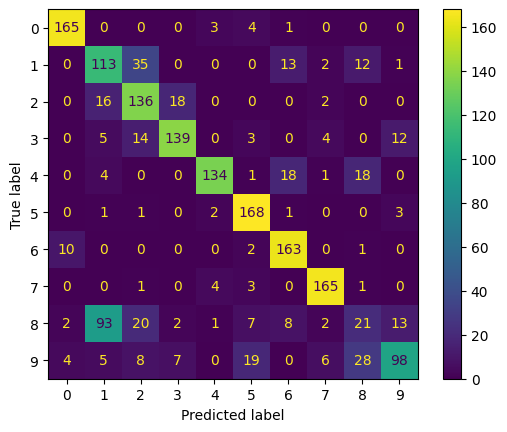

              precision    recall  f1-score   support

           0     0.8731    0.9942    0.9297       173
           1     0.7240    0.7898    0.7554       176
           2     0.8152    0.8721    0.8427       172
           3     0.9702    0.9209    0.9449       177
           4     1.0000    0.9205    0.9586       176
           5     0.9158    0.9886    0.9508       176
           6     0.9435    0.9489    0.9462       176
           7     0.9318    0.9425    0.9371       174
           8     0.6667    0.6391    0.6526       169
           9     0.9044    0.7029    0.7910       175

    accuracy                         0.8727      1744
   macro avg     0.8745    0.8719    0.8709      1744
weighted avg     0.8754    0.8727    0.8718      1744



<Figure size 640x480 with 0 Axes>

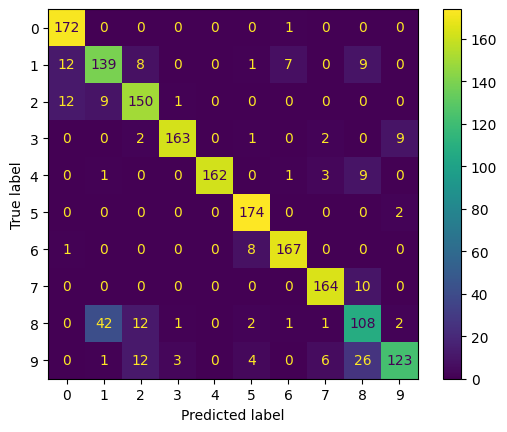

In [30]:
dt_digits.get_classification_report(200, dims=[30])

## PIOR DATASET

              precision    recall  f1-score   support

           0     0.9545    0.7925    0.8660        53
           1     0.8571    0.9524    0.9023        63
           2     0.8667    0.9070    0.8864        43

    accuracy                         0.8868       159
   macro avg     0.8928    0.8839    0.8849       159
weighted avg     0.8922    0.8868    0.8859       159



<Figure size 640x480 with 0 Axes>

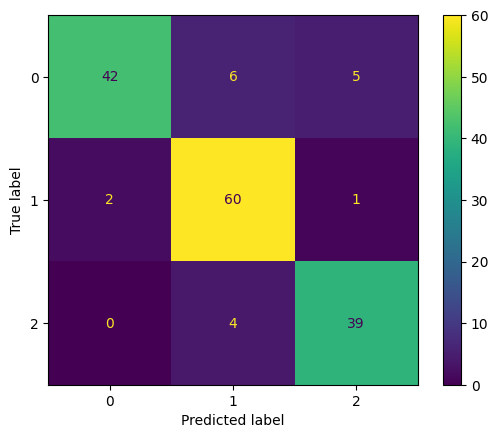

              precision    recall  f1-score   support

           0     0.9545    0.7925    0.8660        53
           1     0.7215    0.9048    0.8028        63
           2     0.7778    0.6512    0.7089        43

    accuracy                         0.7987       159
   macro avg     0.8179    0.7828    0.7926       159
weighted avg     0.8144    0.7987    0.7985       159



<Figure size 640x480 with 0 Axes>

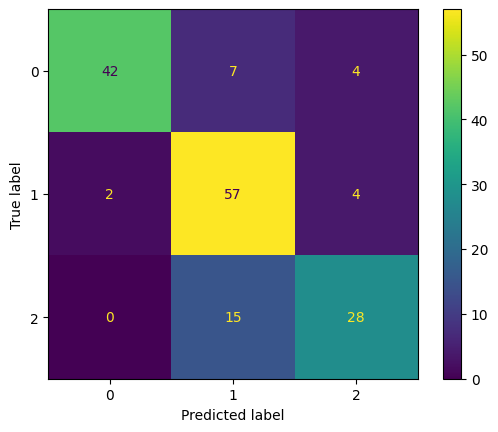

In [31]:
dt_wine.get_classification_report(200, dims=[9])